In [1]:
## Additional Python Packages Needed for This Notebook
# !pip install cartopy
# !pip install gsw
# !pip install matplotlib
# !pip install numpy
# !pip instal pandas
# !pip install xarray

# Thermosalinograph Data from the M/V Spirit of Vancouver Island 

In this example you will be using the Ocean Networks Canada (ONC) Python package to acquire, process, and visualize density data associated with a thermosalinograph installed on the BC Ferry Spirit of Vancouver Island during July 30, 2025.

The `locationCode` for the SOVI begins with `TWDP`.
The `deviceCategoryCode` for the thermosalinograph is `TSG`.

In addition, you will need navigational and system engineering data to clean up the data.
The `locationCode` + `deviceCategoryCode` for these instruments are `TWSB.N1` + `NAV` and `TWSB` + `PVCS`, respectively, over the data dates requested in this notebook.

## Imports

In [2]:
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import gsw
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
import xarray as xr

from onc import ONC
from onc.util import get_onc_token, dt2str
from onc.util.xarray import json2xarray, nan_onc_flags

### Instantiate ONC Class

A utility function is available for retrieving your ONC API token from a .netrc file.
By default the `get_onc_token()` function looks for a `.netrc` file in your home directory.


The `.netrc` file should contain a line like the following:


```
machine data.oceannetworks.ca 
login <your_login> 
password <your_onc_api_token>
```

In [3]:
onc = ONC(token = get_onc_token())

## Acquire Spirit of Vancouver Island (TWSB) Data

In [4]:
%%time
date_from = dt2str(datetime(2025,7,30,0,0,0,0)) # Start of the data request.
date_to = dt2str(datetime(2025,7,30,23,59,59,999999)) # End of the data request.

twsb_loc_dev = [('TWSB.N1','NAV'),
                ('TWSB','PVCS'),
                ('TWSB','TSG')]

ds_list = []
for loc_code, dev_cat_code in twsb_loc_dev:
    
    # See https://data.oceannetworks.ca/OpenAPI#get-/scalardata/location for a complete list of accepted parameters.
    params = {'locationCode': loc_code,
              'deviceCategoryCode': dev_cat_code,
              'dateFrom': date_from,
              'dateTo': date_to,
              'metadata': 'full',
              'qualityControl': 'raw',
              'rowLimit': 100000,
              'outputFormat': 'array'}
    
    json_response_data = onc.getScalardata(filters=params, allPages=True)
    ds = json2xarray(json_response_data)  # Convert the JSON response to an xarray Dataset.
    ds_list.append(ds) # Append the dataset to a list for merging later
    
# Combine the datasets into a single xarray Dataset.
twsb = xr.combine_by_coords(ds_list, join = 'outer',combine_attrs='drop_conflicts') 

CPU times: total: 3.19 s
Wall time: 21.2 s


## Review Dataset

In [5]:
twsb.data_vars

Data variables:
    flag_heave               (time) float32 2MB nan nan nan 1.0 ... nan 1.0 nan
    flag_latitude            (time) float32 2MB 1.0 nan nan nan ... nan nan nan
    flag_longitude           (time) float32 2MB 1.0 nan nan nan ... nan nan nan
    flag_pitch               (time) float32 2MB 1.0 nan nan nan ... nan nan nan
    flag_roll                (time) float32 2MB 1.0 nan nan nan ... nan nan nan
    flag_ship_course         (time) float32 2MB nan nan 1.0 nan ... 1.0 nan nan
    flag_speed_over_ground   (time) float32 2MB nan nan 1.0 nan ... 1.0 nan nan
    flag_true_heading        (time) float32 2MB 1.0 nan nan nan ... nan nan nan
    heave                    (time) float64 3MB nan nan nan ... nan -0.06 nan
    latitude                 (time) float64 3MB 49.01 nan nan ... nan nan nan
    longitude                (time) float64 3MB -123.1 nan nan ... nan nan nan
    pitch                    (time) float64 3MB -3.08 nan nan ... nan nan nan
    roll                     (t

In [6]:
# Root Level Attributes
twsb.attrs

{'qaqcFlagInfo': '0:No Quality Control\n1:Data Passed All Tests\n2:Data Probably Good\n3:Data Probably Bad\n4:Data Bad\n6:Insufficient Valid Data for Reliable Down-Sampling (ONC-defined flag)\n7:Averaged Value (ONC defined flag)\n8:Interpolated Value\n9:Missing Data',
 'depth': 3.0}

In [7]:
# Variable Level Attributes
twsb.practical_salinity.attrs

{'units': 'psu',
 'long_name': 'Practical Salinity',
 'propertyCode': 'salinity',
 'sensorCategoryCode': 'salinity',
 'sensorName': 'Practical Salinity',
 'sensorCode': 'salinity',
 'deviceCategoryCode': 'TSG'}

In [8]:
twsb.flag_practical_salinity.attrs

{'variable': 'practical_salinity',
 'qaqcFlagInfo': '0:No Quality Control\n1:Data Passed All Tests\n2:Data Probably Good\n3:Data Probably Bad\n4:Data Bad\n6:Insufficient Valid Data for Reliable Down-Sampling (ONC-defined flag)\n7:Averaged Value (ONC defined flag)\n8:Interpolated Value\n9:Missing Data'}

## Interpolate Key Variables and Cleanup Data

Not all data from the BC ferries are stamped by location, but they all do share the same common network time. You will need to interpolate to assign a position to each measurement.
 
In the example below, linear interpolation is used for latitude, longitude, pump current, and outlet flow. Nearest neighbor interpolation is used for system state and valve position. 

System state and valve position are state values that indicate whether or not the system is sampling environmental data.
Generally, you will want to look at data where both the system state and valve position are 1, which indicates ON/OPEN.

We will also exclude flowthrough data where the pump current and outlet flow are less than 1, as this likely indicates that water is not being pumped effectively through the system to obtain a measurement that represents the environment.

In [9]:
linear_matchup_vars = ['latitude', 'longitude', 'pump_current','outlet_flow']
for lmv in linear_matchup_vars:
    twsb[lmv] = twsb[lmv].interpolate_na(dim = 'time', method = 'linear', max_gap = timedelta(milliseconds = 3000), fill_value = 'extrapolate')

nearest_matchup_vars = ['system_state', 'valve_position']
for nmv in nearest_matchup_vars:
    twsb[nmv] = twsb[nmv].interpolate_na(dim = 'time', method = 'nearest', max_gap = timedelta(milliseconds = 3000), fill_value = 'extrapolate')

In [10]:
# Remove data based on other engineering data. 
# If the following conditions are not met, then we consider ALL data at that time to be invalid.
twsb = twsb.where(twsb['system_state'] == 1, drop = True)
twsb = twsb.where(twsb['valve_position'] == 1, drop = True)
twsb = twsb.where(twsb['outlet_flow'] >= 1, drop = True)
twsb = twsb.where(twsb['pump_current'] >= 1, drop = True)

# Also remove any data that failed ONC QAQC tests. 
# The nan_onc_flags utility function only nullifies data in the corresponding variable.
twsb = nan_onc_flags(twsb, flags_to_nan=[4]) 

## Calculate Sea Water Density

In [11]:
p = gsw.p_from_z(3, twsb['latitude']) # The intake is approximately 3 meters below the average water line of the vessel.
sa = gsw.SA_from_SP(twsb['practical_salinity'], p, twsb['longitude'], twsb['latitude']) # Absolute Salinity
ct = gsw.CT_from_t(sa, twsb['temperature'], p) # Conservative Temperature
twsb['density'] = gsw.density.rho(sa, ct, p) 

## Resample and Subset

In [12]:
# Resample to 30 second intervals to reduce the number of points to plot.
twsb = twsb.resample({'time': '30s'}, skipna = True).mean()

# Only keep variables of interest and remove any nans to simplify plotting.
twsb = twsb[['latitude','longitude','density']].dropna(dim = 'time', how = 'any')

## Define Terminal Locations

In [13]:
class Tsawwassen:
    latitude: float = 49.006621
    longitude: float = -123.132309
    
class SwartzBay:
    latitude: float = 48.689047
    longitude: float = -123.410817

## Static Plot

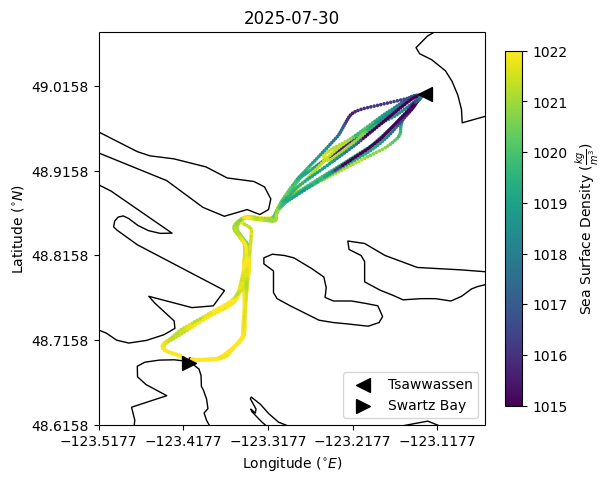

In [14]:
t = twsb.time.values
x = twsb.longitude.values
y = twsb.latitude.values
c = twsb.density.values

xmin, xmax = np.nanmin(x) - 0.075, np.nanmax(x) + 0.075
ymin, ymax = np.nanmin(y)  - 0.075, np.nanmax(y)  + 0.075
major_locator = 0.1 
vmin, vmax = 1015,1022 # Density min/max for color scale.

cmap = matplotlib.colormaps.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = vmin , vmax = vmax) 

crs = ccrs.PlateCarree()
fig, ax = plt.subplots(1,1,figsize = (6,6), constrained_layout = True, subplot_kw={'projection': crs})
ax.set_extent([xmin, xmax, ymin, ymax])
ax.coastlines()

pscat = ax.scatter(x, y, c = c, cmap = 'viridis', vmin = vmin, vmax = vmax, s=10, marker = '.')
ax.set_title(pd.to_datetime(t[0]).strftime('%Y-%m-%d'))
ax.set_xticks(np.arange(xmin, xmax,major_locator))
ax.set_yticks(np.arange(ymin, ymax,major_locator))
ax.set_xlabel(r'Longitude ($^{\circ}E$)')
ax.set_ylabel(r'Latitude ($^{\circ}N$)')
cbar = fig.colorbar(pscat, ax = ax, cmap = cmap, norm = norm, label = r'Sea Surface Density ($\frac{kg}{m^3}$)', shrink = 0.6)

ax.scatter(Tsawwassen.longitude, Tsawwassen.latitude, marker = '<', color = 'black', s = 100, label = 'Tsawwassen')
ax.scatter(SwartzBay.longitude, SwartzBay.latitude, marker = '>', color = 'black', s = 100, label = 'Swartz Bay')

ax.legend(loc = 'lower right')

plt.show()

## Build Animation

In [15]:
%matplotlib notebook

t = twsb.time.values
x = twsb.longitude.values
y = twsb.latitude.values
c = twsb.density.values

xmin, xmax = np.nanmin(x) - 0.075, np.nanmax(x) + 0.075
ymin, ymax = np.nanmin(y)  - 0.075, np.nanmax(y)  + 0.075
major_locator = 0.1 
vmin, vmax = 1015,1022 # Density min/max for color scale.

cmap = matplotlib.colormaps.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = vmin , vmax = vmax) 

crs = ccrs.PlateCarree()
fig, ax = plt.subplots(1,1,figsize = (6,6), constrained_layout = True, subplot_kw={'projection': crs})
ax.set_extent([xmin, xmax, ymin, ymax])
ax.coastlines()

pscat = ax.scatter(x[0], y[0], c = c[0], cmap = 'viridis', vmin = vmin, vmax = vmax, s=10, marker = '.')
ax.set_title(pd.to_datetime(t[0]).strftime('%Y-%m-%dT%H:%M:%SZ'))
ax.set_xticks(np.arange(xmin, xmax,major_locator))
ax.set_yticks(np.arange(ymin, ymax,major_locator))
ax.set_xlabel(r'Longitude ($^{\circ}E$)')
ax.set_ylabel(r'Latitude ($^{\circ}N$)')
cbar = fig.colorbar(pscat, ax = ax, cmap = cmap, norm = norm, label = r'Sea Surface Density ($\frac{kg}{m^3}$)', shrink = 0.6)


ax.scatter(Tsawwassen.longitude, Tsawwassen.latitude, marker = '<', color = 'black', s = 100, label = 'Tsawwassen')
ax.scatter(SwartzBay.longitude, SwartzBay.latitude, marker = '>', color = 'black', s = 100, label = 'Swartz Bay')

ax.legend(loc = 'lower right')


def update(frame):
    data = np.stack([x[:frame], y[:frame]]).T
    pscat.set_offsets(data)
    pscat.set_color(cmap(norm(c[:frame])))
    ax.set_title(pd.to_datetime(t[frame]).strftime('%Y-%m-%dT%H:%M:%SZ'))
    
    return pscat,

ani = FuncAnimation(fig=fig, func=update, frames=len(t), interval=1, blit = False)
plt.show()

<IPython.core.display.Javascript object>